In [1]:
import numpy as np
from numpy.fft import rfft, rfftfreq
from scipy.sparse import spdiags
from scipy import signal
from scipy.ndimage import zoom
import scipy.io

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm

from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees,degrees2kilometers
from obspy.signal import filter as obspy_filter
import time
from scipy import interpolate
import obspy

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
proj=ccrs.PlateCarree()

import pyproj
geodesic = pyproj.Geod(ellps='WGS84')

import time

import sys
sys.path.append('/home/yaolinm/Projects/Mexico2/')
sys.path.append('/home/yaolinm/Projects/Mexico/a1das-v2-main/')

from funcs.bp import *
from funcs.mccc import *
from funcs.utils import *
from a1das import core

from numba import njit
import numba
import copy
import glob,os,h5py
from obspy.core import UTCDateTime as UTC
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees

# new F5

In [8]:
### read selected station locations, synthetic sensors at the same locations

sac_files=np.sort(glob.glob('/home/yaolinm/Projects/Mexico2/data/teleseismic/SAC/*00*'))
station_file=glob.glob('/home/yaolinm/Projects/Mexico2/data/teleseismic/*.txt')[0]

stations0,distances0,azimuths0,networks0,longitudes0,latitudes0=[],[],[],[],[],[]

for sac_file in sac_files:
    
    wildcard=os.path.basename(sac_file).split('.BHZ')[0]
    stations0.append(wildcard.split('.')[1])
    networks0.append(wildcard.split('.')[0])

file=open(station_file,'r')
lines=file.readlines()[1:]
txtstations,txtdistances,txtazimuths,txtlongitudes,txtlatitudes=[],[],[],[],[]

for line in lines:
    items=line.split('|')
    txtstations.append(items[0])
    txtdistances.append(float(items[5]))
    txtazimuths.append(float(items[6]))
    txtlatitudes.append(float(items[3]))
    txtlongitudes.append(float(items[4]))

for station in stations0:
    idx=txtstations.index(station)
    distances0.append(txtdistances[idx])
    azimuths0.append(txtazimuths[idx])
    longitudes0.append(txtlongitudes[idx])
    latitudes0.append(txtlatitudes[idx])
    
sacs=np.sort(glob.glob('/home/yaolinm/Projects/Mexico2/data/teleseismic/*.sac'))
idxs=[]
df=np.zeros((len(sacs),120*20))
for i in range(len(sacs)):
    tr=obspy.read(sacs[i])[0]
    tr.filter('bandpass',freqmin=0.05,freqmax=0.2)
    
    if azimuths0[i]<=-120:
        starting=44
    else:
        starting=50
    
    if tr.stats.sampling_rate==20:
        df[i,:]=tr.data[starting*20:starting*20+2400]
        
    elif tr.stats.sampling_rate==40:
        df[i,:]=signal.decimate(tr.data[starting*40:starting*40+4800],2)
        
    else:
        print(sacs[i])
        
    if np.sum(np.abs(df[i][400:800]))/np.sum(np.abs(df[i][:400]))>=5:
        idxs.append(i)
        
df=df[np.array(idxs)]
stations,distances,azimuths,networks,longitudes,latitudes=[],[],[],[],[],[]
for idx in idxs:
    stations.append(stations0[idx])
    distances.append(distances0[idx])
    azimuths.append(azimuths0[idx])
    networks.append(networks0[idx])
    longitudes.append(longitudes0[idx])
    latitudes.append(latitudes0[idx])
# plt.figure(dpi=300,figsize=(3,4))
# amplifier=20

to_mccc,solutions=iterative_mccc(df,360,600,10)
for i in range(len(to_mccc)):
    to_mccc[i,:]/=np.max(np.abs(to_mccc[i,:]))

# ### plot after MCCC
# plt.figure(dpi=300,figsize=(3,4))
# amplifier=20

# for i in range(len(to_mccc)):
#     tr=normalize(to_mccc[i,:])
#     plt.plot(amplifier*tr+azimuths[i],lw=0.5,c='k')
    
# plt.plot(amplifier*normalize(np.mean(to_mccc,axis=0))+220,lw=0.5,c='r')

# plt.ylabel('Azimuth')
# plt.xticks([0,400,800,1200,1600,2000,2400],[-20,0,20,40,60,80,100])
# plt.xlabel('Seconds')
# plt.xlim(0,2400)

# plt.yticks([-180,-120,-60,0,60,120,180,220],[-180,-120,-60,0,60,120,180,'stacked'])
# plt.ylim(-190,260)

35.712626 seconds


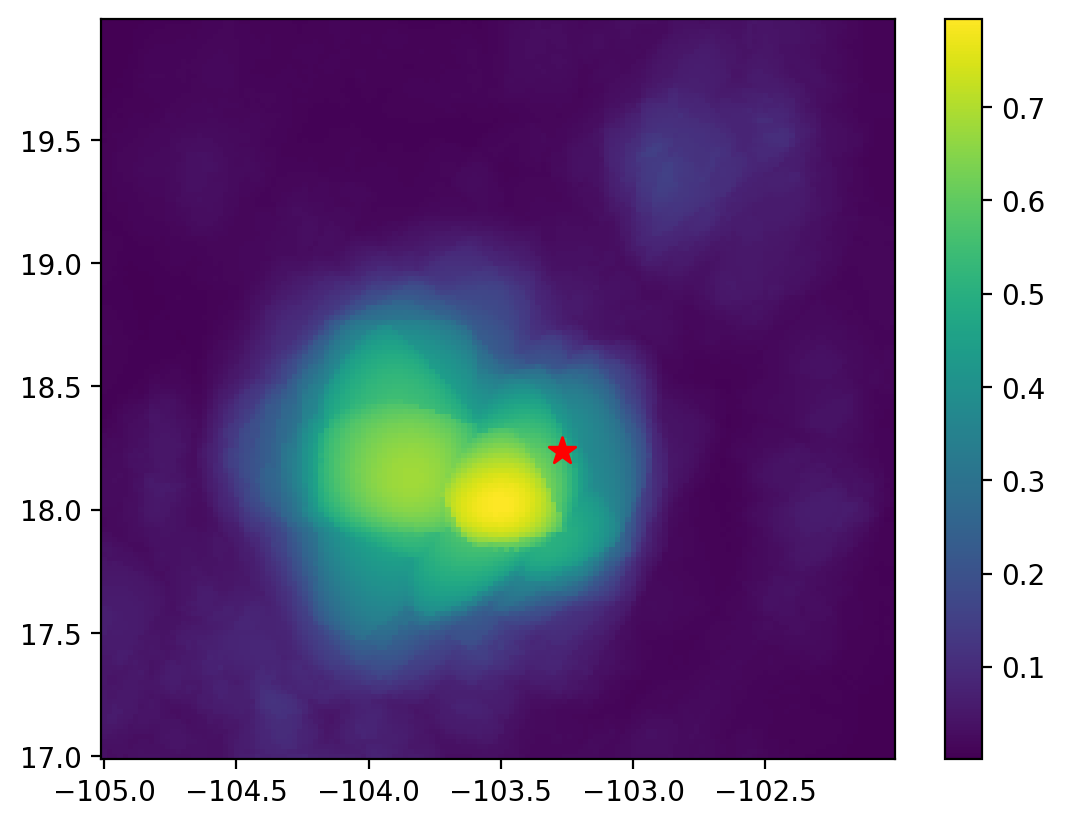

In [3]:
eq=earthquake(-103.269,18.2377,25.5)
longitude_range=[-105,-102]
latitude_range=[17,20]
grid=gridize(longitude_range,latitude_range,stepsize=0.02)

global_rtable=reference_table(model='iasp91',eq=eq,wave='P')
corners=[[latitude_range[0],longitude_range[0]],[latitude_range[0],longitude_range[1]],[latitude_range[1],longitude_range[0]],[latitude_range[1],longitude_range[1]]]
degrees=[]
for corner in corners:
    for i in range(len(latitudes)):
        degrees.append(locations2degrees(latitudes[i],longitudes[i],corner[0],corner[1]))
        
global_rtable.cal_table(np.min(degrees)-0.05,np.max(degrees)+0.05,0.1)


refs=[]
global_sensors=[]    
for i in range(len(to_mccc)):
    global_sensor=sensor(longitudes[i],latitudes[i],trace_len=2400,sampling=20,eq_start=20)
    global_sensor.add_seis_trace(to_mccc[i,:])
    global_sensor.cal_epitime(eq,global_rtable)
    global_sensor.calculate_ttime(grid,global_rtable)
    global_sensors.append(global_sensor)
bp_global=bp_bmfm(global_sensors,global_rtable,grid,eq)
start = time.time()
bp_global.run_bp()
end = time.time()
print(f"{end - start:.6f} seconds")
bp_global.plot_bp()

In [4]:
rmss=[]
for i in np.arange(15,95,0.1):
    
    pt=int(i*20)
    rmss.append(np.mean(np.max(np.abs(bp_global.master[:,:,pt:pt+100]),axis=-1)))

In [5]:
import netCDF4 as nc
import cmocean
file='/home/yaolinm/Projects/Mexico2/data/gebco_2024_n21.0_s16.0_w-106.0_e-101.0.nc'
dataset = nc.Dataset(file, 'r')
variable = dataset.variables['elevation']
bmap = variable[:] 

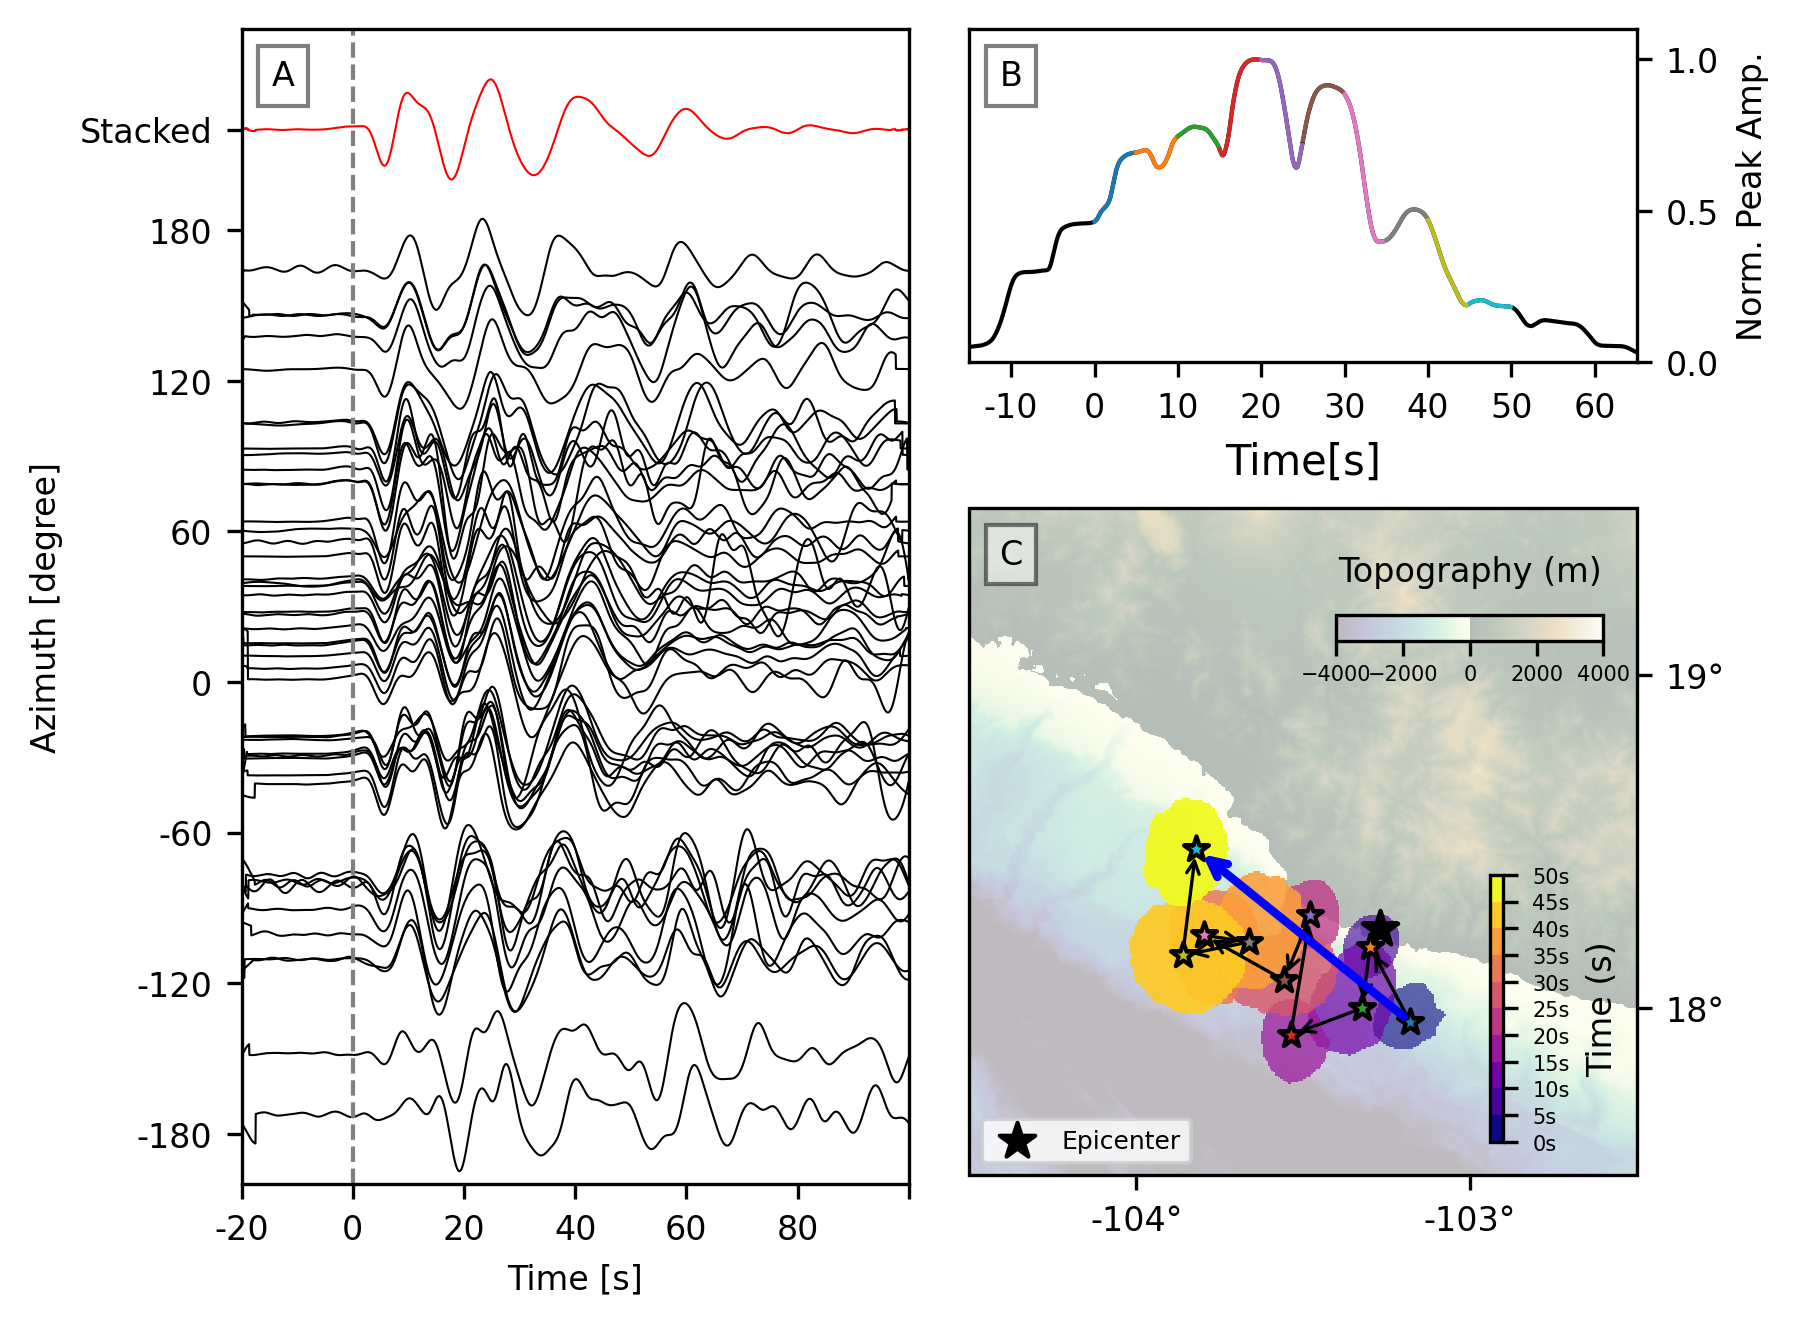

In [14]:
x_mesh,y_mesh=bp_global.grid.mesh()
longitude_range=[-104.25,-102.75]
latitude_range=[17.75,19.25]
grid=gridize(longitude_range,latitude_range,stepsize=0.02)
resized_x_mesh=zoom(x_mesh,zoom=4,order=1)
resized_y_mesh=zoom(y_mesh,zoom=4,order=1)

fig=plt.figure(dpi=300,figsize=(6,5))
fig.subplots_adjust(hspace=0.2,wspace=0.2)
proj=cartopy.crs.PlateCarree()

ax0 = plt.subplot2grid(shape=(10,4), loc=(0,0), colspan=2,rowspan=10)
ax1 = plt.subplot2grid(shape=(10,4), loc=(0,2), colspan=2,rowspan=3)
ax2 = plt.subplot2grid(shape=(10,4), loc=(4,2), colspan=2,rowspan=6,projection=proj)

amplifier=20
to_mccc,solutions=iterative_mccc(df,360,600,10)
for i in range(len(to_mccc)):
    to_mccc[i,:]/=np.max(np.abs(to_mccc[i,:]))

for i in range(len(to_mccc)):
    tr=normalize(to_mccc[i,:])
    ax0.plot(amplifier*tr+azimuths[i],lw=0.5,c='k')
    
ax0.plot(amplifier*normalize(np.mean(to_mccc,axis=0))+220,lw=0.5,c='r')
ax0.vlines(400,-200,260,color='grey',ls='--',lw=1)

ax0.set_ylabel('Azimuth [degree]',fontsize=8)
ax0.set_xticks([0,400,800,1200,1600,2000,2400])
ax0.set_xticklabels([-20,0,20,40,60,80,''],fontsize=8)
ax0.set_xlabel('Time [s]',fontsize=8)
ax0.set_xlim(0,2400)

ax0.set_yticks([-180,-120,-60,0,60,120,180,220])
ax0.set_yticklabels([-180,-120,-60,0,60,120,180,'Stacked'],fontsize=8)
ax0.set_ylim(-200,260)

colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Yellow-green
    "#17becf"   # Cyan
]

ax1.plot(normalize(rmss),lw=1,c='k')
ax1.yaxis.set_ticks_position('right')
ax1.yaxis.set_label_position("right")
# ax1.xaxis.set_ticks_position('top')
# ax1.xaxis.set_label_position('top')
ax1.set_ylim(0,1.1)
ax1.set_xticks([50,150,250,350,450,550,650,750])
ax1.set_xticklabels([-10,0,10,20,30,40,50,60],fontsize=8)
ax1.set_xlim(0,800)
ax1.set_xlabel('Time[s]')
ax1.set_ylabel('Norm. Peak Amp.',fontsize=8)
for c,t in enumerate(np.arange(10,60,5)):
    ax1.plot(np.arange(10*t+50,10*t+100),normalize(rmss)[10*t+50:10*t+100],lw=1,c=colors[c])
ax1.tick_params(axis='y', labelsize=8) 

x_mesh,y_mesh=bp_global.grid.mesh()

from scipy.ndimage import zoom
from matplotlib.colors import ListedColormap, BoundaryNorm
n_bins = 10
cmap_name = 'plasma'  
original_cmap = plt.get_cmap(cmap_name)
discrete_colors = original_cmap(np.linspace(0, 1, n_bins))
colormaps = [ListedColormap(color,color) for color in discrete_colors]

bs=ax2.imshow(np.flipud(bmap[240:960,240:960]),cmap=cmocean.cm.topo,vmin=-4000,vmax=4000,
              alpha=0.3,extent=[-105.02,-102,16.98,20],transform=proj)

peak_positions1 = []

for i in range(10,60,5):

    data=fetch_sliced_image(bp_global.master,i,10,time_window=1,temporal_averageing=5)
    data=normalize(np.max(data,axis=-1))
    maxs=np.unravel_index(np.argmax(data),data.shape)

    resized_data=zoom(data,zoom=4,order=1)
    max_idx = np.unravel_index(np.argmax(resized_data), resized_data.shape)
    peak_x, peak_y = resized_x_mesh[(max_idx[1],max_idx[0])], resized_y_mesh[(max_idx[1],max_idx[0])]
    peak_positions1.append((peak_x, peak_y, colors[(i-10)//5]))
    z=np.ma.masked_array(resized_data,resized_data<0.9)
    
    pc=ax2.pcolormesh(resized_x_mesh,resized_y_mesh,z.T,vmin=0.8,vmax=1,cmap=colormaps[(i-10)//5],
                      alpha=(i-10)/125+0.6,transform=proj)

ax2.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=80,label='Epicenter')
ax2.set_xticks([-104, -103])
ax2.set_xticklabels( [f"{x}°" for x in [ -104, -103]], fontsize=8)
ax2.set_yticks([18, 19])
ax2.set_yticklabels([f"{y}°" for y in [18, 19]], fontsize=8)
ax2.set_xlim(-104.5,-102.5)
ax2.set_ylim(17.5,19.5)
ax2.yaxis.set_ticks_position('right')

for peak_x, peak_y, color in peak_positions1:
    ax2.scatter(peak_x, peak_y, marker='*', s=40, facecolor=color, edgecolor='black', 
               linewidth=1, zorder=10,transform=proj)

for j in range(len(peak_positions1) - 1):
    x1, y1, _ = peak_positions1[j]
    x2, y2, _ = peak_positions1[j + 1]
    
    ax2.annotate("", xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="->,head_width=0.15,head_length=0.3", color='black', lw=0.8), zorder=11,transform=proj)

x1, y1, _ = peak_positions1[0]
x2, y2, _ = peak_positions1[-1]

ax2.annotate("", xy=(x2, y2), xytext=(x1, y1),
            arrowprops=dict(arrowstyle="->", color='b', lw=2), zorder=11,transform=proj)

cax1 = ax2.inset_axes([0.55, 0.8, 0.4, 0.04]) 
cbar1 = fig.colorbar(bs, cax=cax1, orientation='horizontal')
cbar1.set_label("Topography (m)", fontsize=8, labelpad=8)
cbar1.ax.xaxis.set_label_position("top")
cbar1.ax.tick_params(labelsize=5, pad=2) 

cmap_custom = ListedColormap(discrete_colors)
bounds = np.linspace(10, 60, 11) 
norm = BoundaryNorm(bounds, cmap_custom.N)

cax2 = ax2.inset_axes([0.78, 0.05, 0.02, 0.4]) 
cbar2 = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap_custom), cax=cax2, orientation='vertical')
cbar2.set_label("Time (s)", fontsize=8)
cbar2.set_ticks(bounds)
cbar2.set_ticklabels([f"{int(b-10)}s" for b in bounds])
cbar2.ax.tick_params(labelsize=5)

ax2.legend(fontsize=6, loc='lower left')

at = AnchoredText('A',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax0.add_artist(at)

at = AnchoredText('B',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax1.add_artist(at)

at = AnchoredText('C',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax2.add_artist(at)

# F6

In [8]:
valid_chs=np.load('data/das_bp_results/valid_chs.npy')

egf1_p_correlogram=np.load('data/das_bp_results/egf1_p_correlogram2.npy')
egf1_s_correlogram=np.load('data/das_bp_results/egf1_s_correlogram.npy')
egf2_p_correlogram=np.load('data/das_bp_results/egf2_p_correlogram2.npy')
egf2_s_correlogram=np.load('data/das_bp_results/egf2_s_correlogram.npy')

p1=normalize(pws_stack(egf1_p_correlogram[valid_chs,:],axis=0))
p2=normalize(pws_stack(egf2_p_correlogram[valid_chs,:],axis=0))
s1=normalize(pws_stack(egf1_s_correlogram[valid_chs,:],axis=0))
s2=normalize(pws_stack(egf2_s_correlogram[valid_chs,:],axis=0))

P_correlograms=np.zeros((221,5000))
P_correlograms[:,1250:3750]=egf1_p_correlogram[valid_chs[::4],:][:,:2500]
S_correlograms=np.zeros((221,5000))
S_correlograms[:,1250:3750]=egf1_s_correlogram[valid_chs[::4],:][:,:2500]

pwsed_bp_P_subs,pwsed_bp_S_subs=[],[]

pwsed_bp_P_subs.append(np.load('data/das_bp_results/pwsed_bp_P_sub1.npy'))
pwsed_bp_P_subs.append(np.load('data/das_bp_results/pwsed_bp_P_sub2.npy'))
pwsed_bp_P_subs.append(np.load('data/das_bp_results/pwsed_bp_P_sub3.npy'))

pwsed_bp_S_subs.append(np.load('data/das_bp_results/pwsed_bp_S_sub1.npy'))
pwsed_bp_S_subs.append(np.load('data/das_bp_results/pwsed_bp_S_sub2.npy'))
pwsed_bp_S_subs.append(np.load('data/das_bp_results/pwsed_bp_S_sub3.npy'))

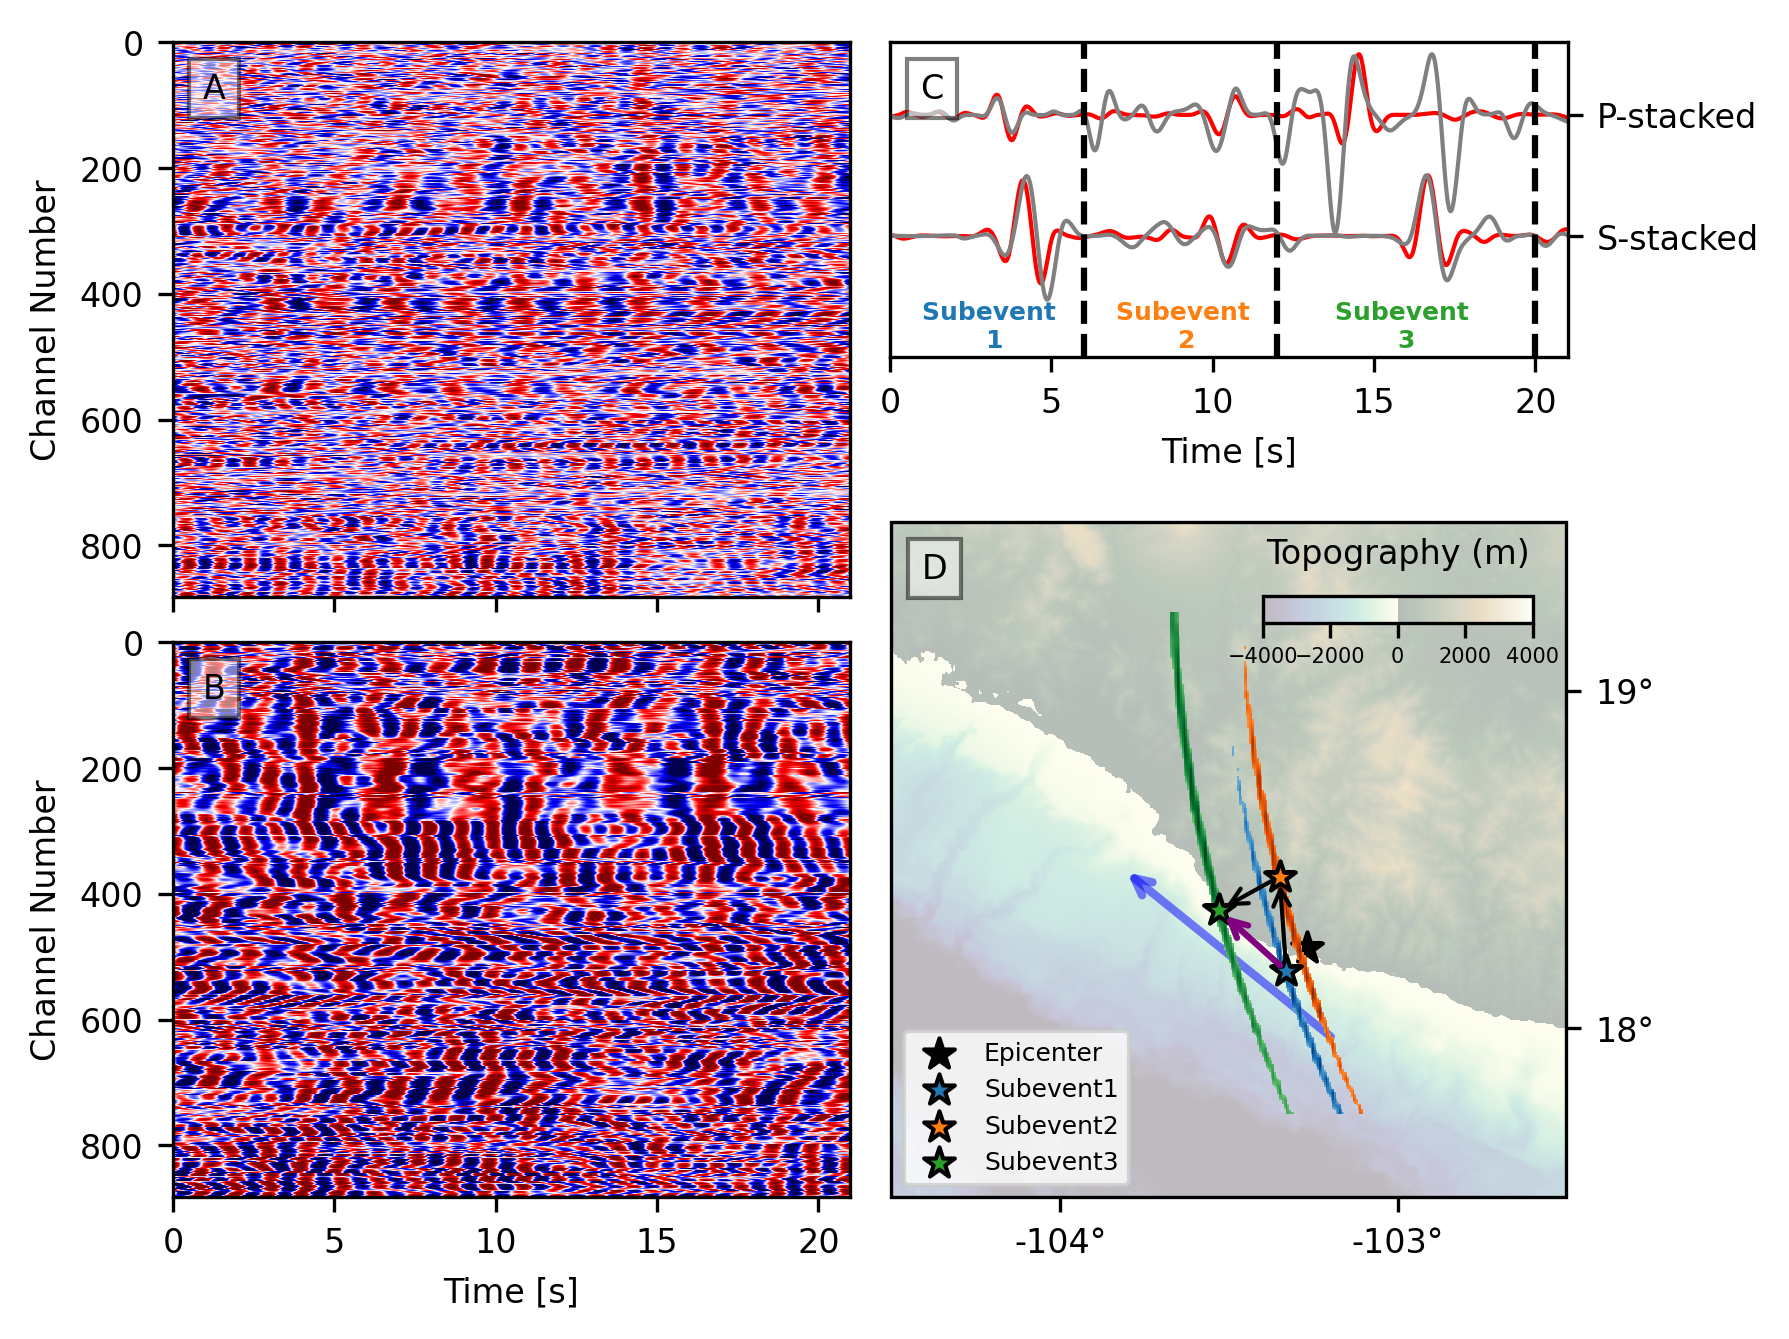

In [16]:
proj=cartopy.crs.PlateCarree()

colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Yellow-green
    "#17becf"   # Cyan
]
colormaps = [mpl.colormaps['Blues'],mpl.colormaps['Oranges'],mpl.colormaps['Greens']] 

fig=plt.figure(dpi=300,figsize=(6,5))
fig.subplots_adjust(hspace=0.6,wspace=0.2)

ax0 = plt.subplot2grid(shape=(10,6), loc=(0,0), colspan=3,rowspan=5)
ax1 = plt.subplot2grid(shape=(10,6), loc=(5,0), colspan=3,rowspan=5)
ax2 = plt.subplot2grid(shape=(10,6), loc=(0,3), colspan=3,rowspan=3)
ax3 = plt.subplot2grid(shape=(10,6), loc=(4,3), colspan=3,rowspan=6,projection=proj)

ax0.imshow(normalize_df(egf1_p_correlogram[valid_chs,:1050]),aspect='auto',vmin=-0.8,vmax=0.8,cmap='seismic')
ax0.set_ylabel('Channel Number',fontsize=8)
ax0.set_xticks([0,250,500,750,1000])
ax0.set_xticklabels(['','','','',''])
ax0.tick_params(axis='y', labelsize=8) 

ax1.imshow(normalize_df(egf1_s_correlogram[valid_chs,:1050]),aspect='auto',vmin=-0.6,vmax=0.6,cmap='seismic')
ax1.set_ylabel('Channel Number',fontsize=8)
ax1.set_xticks([0,250,500,750,1000])
ax1.set_xticklabels([0,5,10,15,20],fontsize=8)
ax1.set_xlabel('Time [s]',fontsize=8)
ax1.tick_params(axis='y', labelsize=8) 

ax2.plot(p1,lw=1,c='r')
ax2.plot(p2,lw=1,c='grey')
ax2.plot(s1-2,lw=1,c='r')
ax2.plot(s2-2,lw=1,c='grey')
ax2.vlines(300,-4,1.2,colors='k',ls='--')
ax2.vlines(600,-4,1.2,colors='k',ls='--')
ax2.vlines(1000,-4,1.2,colors='k',ls='--')
ax2.text(160,-3.5,'Subevent \n1',va='center',ha='center',fontsize=6,c='#1f77b4',weight='bold')
ax2.text(460,-3.5,'Subevent \n2',va='center',ha='center',fontsize=6,c='#ff7f0e',weight='bold')
ax2.text(800,-3.5,'Subevent \n3',va='center',ha='center',fontsize=6,c='#2ca02c',weight='bold')

ax2.set_xlim(0,1050)
# ax2.xaxis.set_ticks_position('top')
# ax2.xaxis.set_label_position('top')
ax2.set_xticks([0,250,500,750,1000])
ax2.set_xticklabels([0,5,10,15,20],fontsize=8)
ax2.set_xlabel('Time [s]',fontsize=8)

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position("right")
ax2.set_yticks([0,-2])
ax2.set_yticklabels(['P-stacked','S-stacked'],fontsize=8)
ax2.set_ylim(-4,1.2)

longitude_range=[-104.25,-102.75]
latitude_range=[17.75,19.25]
grid=gridize(longitude_range,latitude_range,stepsize=0.02)
x_mesh,y_mesh=grid.mesh()
resized_x_mesh=zoom(x_mesh,zoom=4,order=1)
resized_y_mesh=zoom(y_mesh,zoom=4,order=1)

taper_func=signal.windows.get_window('hann',250)
colormaps = [mpl.colormaps['Blues'],mpl.colormaps['Oranges'],mpl.colormaps['Greens']] 

peak_positions2 = []    
    
bs=ax3.imshow(np.flipud(bmap[240:960,240:960]),cmap=cmocean.cm.topo,vmin=-4000,vmax=4000,
              alpha=0.3,extent=[-105.02,-102,16.98,20],transform=proj)
x1, y1, _ = peak_positions1[0]
x2, y2, _ = peak_positions1[-1]
ax3.annotate("", xy=(x2, y2), xytext=(x1, y1),
            arrowprops=dict(arrowstyle="->", color='b', lw=2,alpha=0.5), zorder=11,transform=proj,alpha=0.6)
    
ax3.set_xticks([-104, -103])
ax3.set_xticklabels( [f"{x}°" for x in [ -104, -103]], fontsize=8)
ax3.set_yticks([18, 19])
ax3.set_yticklabels([f"{y}°" for y in [18, 19]], fontsize=8)
ax3.set_xlim(-104.5,-102.5)
ax3.set_ylim(17.5,19.5)
ax3.yaxis.set_ticks_position('right')

for ph in range(3):
    
    sumed=normalize(pwsed_bp_P_subs[ph])+normalize(pwsed_bp_S_subs[ph])
    sumed[sumed==np.inf]=0
    master=np.max(sumed,axis=-1)
    loc=np.unravel_index(np.argmax(master),master.shape)
    peak_x, peak_y = x_mesh[(loc[1],loc[0])], y_mesh[(loc[1],loc[0])]
    peak_positions2.append((peak_x, peak_y, colors[ph]))

    taper=np.zeros(5000)
    taper[np.argmax(sumed[loc[0],loc[1]])-125:np.argmax(sumed[loc[0],loc[1]])+125]=taper_func
    sumed*=taper

    master=np.max(sumed,axis=-1)
    resized_data=zoom(master,zoom=4,order=1)
    z=np.ma.masked_array(resized_data,resized_data<0.9*np.max(resized_data))
    max_idx = np.unravel_index(np.argmax(resized_data), resized_data.shape)

    pc=ax3.pcolormesh(resized_x_mesh,resized_y_mesh,z.T,vmin=0.8*np.max(resized_data),cmap=colormaps[ph],zorder=12)


ax3.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=60,label='Epicenter')
for c,(peak_x, peak_y, color) in enumerate(peak_positions2):
    ax3.scatter(peak_x, peak_y, marker='*', s=60, facecolor=color, edgecolor='k', 
               linewidth=1, zorder=14,transform=proj,label='Subevent'+str(c+1))
    
for j in range(len(peak_positions2) - 1):
    x1, y1, _ = peak_positions2[j]
    x2, y2, _ = peak_positions2[j + 1]
    
    ax3.annotate("", xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="->", color='black', lw=1), zorder=13,transform=proj)
    
x1, y1, _ = peak_positions2[0]
x2, y2, _ = peak_positions2[-1]

ax3.annotate("", xy=(x2, y2), xytext=(x1, y1),
            arrowprops=dict(arrowstyle="->", color='purple', lw=1.5), zorder=15,transform=proj)

ax3.legend(fontsize=6,loc='lower left')
    
cax1 = ax3.inset_axes([0.55, 0.85, 0.4, 0.04]) 
cbar1 = fig.colorbar(bs, cax=cax1, orientation='horizontal')
cbar1.set_label("Topography (m)", fontsize=8, labelpad=8)
cbar1.ax.xaxis.set_label_position("top")
cbar1.ax.tick_params(labelsize=5, pad=2) 

at = AnchoredText('A',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax0.add_artist(at)

at = AnchoredText('B',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax1.add_artist(at)

at = AnchoredText('C',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax2.add_artist(at)

at = AnchoredText('D',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax3.add_artist(at)